## Import

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# train.data.float().mean()/255.0, train.data.float().std() /255.0
# test.data.float().mean()/255.0, test.data.float().std() /255.0

In [5]:
train_trans = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(45),
    transforms.Grayscale(num_output_channels=3),
    ToTensor(),
    transforms.Normalize((0.1307,), (0.3181,))
])

test_trans = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    ToTensor(),
    transforms.Normalize((0.1325,), (0.3105,))
])

train = datasets.MNIST(
    root='data',
    train=True,
    download=False,
    transform=train_trans
)

test = datasets.MNIST(
    root='data',
    train=False,
    download=False,
    transform=test_trans
)

## Parameters

In [6]:
batch_size = 256
learning_rate = 0.0001
epochs = 30

trainloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

In [9]:
model = models.vgg19_bn(num_classes=10, weights=None)
# model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
model = model.to(device)

In [10]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [12]:
def train(net, trainloader, validloader, criterion, optimizer, num_epochs):
    net.train()

    train_losses = []  # To store training losses
    valid_losses = []  # To store validation losses
    train_accuracies = []  # To store training accuracies
    valid_accuracies = []  # To store validation accuracies

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in trainloader:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total_train += labels.size(0)
          correct_train += predicted.eq(labels).sum().item()

        average_train_loss = running_loss / len(trainloader)
        train_losses.append(average_train_loss)
        training_accuracy = 100 * correct_train / total_train
        train_accuracies.append(training_accuracy)

        # Validation loop
        net.eval()  # Set the network to evaluation mode
        correct_valid = 0
        total_valid = 0
        valid_loss = 0.0

        with torch.no_grad():
          for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

        average_val_loss = running_loss / len(testloader)
        valid_losses.append(average_val_loss)
        validation_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(validation_accuracy)

        print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {training_accuracy:.2f}%, Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')

    print('Finished Training')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

Epoch 1, Training Loss: 0.6143, Training Accuracy: 80.98%, Validation Loss: 3.7180, Validation Accuracy: 96.75%
Epoch 2, Training Loss: 0.1181, Training Accuracy: 96.56%, Validation Loss: 0.7676, Validation Accuracy: 97.72%
Epoch 3, Training Loss: 0.0861, Training Accuracy: 97.55%, Validation Loss: 0.5723, Validation Accuracy: 98.20%
Epoch 4, Training Loss: 0.0733, Training Accuracy: 97.97%, Validation Loss: 0.4754, Validation Accuracy: 98.56%
Epoch 5, Training Loss: 0.0622, Training Accuracy: 98.21%, Validation Loss: 0.4239, Validation Accuracy: 98.38%
Epoch 6, Training Loss: 0.0575, Training Accuracy: 98.41%, Validation Loss: 0.3809, Validation Accuracy: 98.73%
Epoch 7, Training Loss: 0.0551, Training Accuracy: 98.50%, Validation Loss: 0.3997, Validation Accuracy: 98.00%
Epoch 8, Training Loss: 0.0483, Training Accuracy: 98.69%, Validation Loss: 0.3308, Validation Accuracy: 98.73%
Epoch 9, Training Loss: 0.0458, Training Accuracy: 98.80%, Validation Loss: 0.3008, Validation Accuracy:

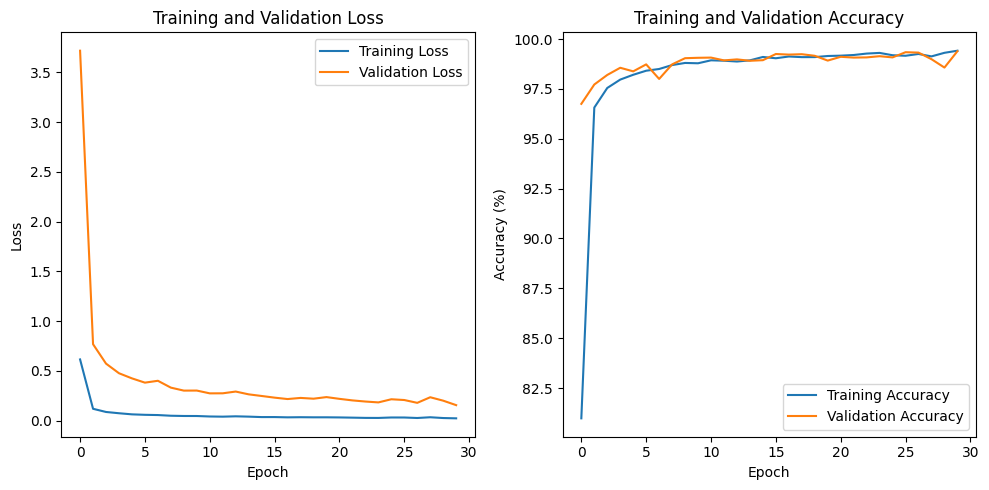

In [13]:
train(model, trainloader, testloader, criterion, optimizer, epochs)

In [1]:
torch.save(model.state_dict(), 'Cv_Dl_model1.pth')

NameError: ignored